In [2]:
# structure de données
import pandas as pd
import numpy as np

# Traitement de texte
from bs4 import BeautifulSoup
import re
import nltk

# graphique
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [3]:
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# A. Importation des données

##### Fichiers csv provenant de l'extraction SQL de StackOverFlow. Seule une partie de la table "posts" a été récupérée

In [4]:
train = pd.read_csv("train.csv", sep=',', header=0)
test = pd.read_csv('test.csv', sep=',', header=0)

In [5]:
print("La table d'entrainement a {} posts et {} variables".format(
    train.shape[0], train.shape[1]))
train.head()

La table d'entrainement a 204432 posts et 9 variables


,Id,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,26477388,23,5693.0,<p>In SBT is the use of <em>aggregate</em> fol...,Is the use of 'aggregate' following by 'depend...,<build><sbt>,1.0,0,9.0
1,20580028,22,37747.0,"<p>I'm designed a <a href=""http://en.wikipedia...","Flowchart ""for each"" loop loop without variabl...",<flowchart>,5.0,1,2.0
2,15096219,22,21065.0,<p>I'm trying to register a new log</p>\n\n<pr...,How to create a folder (if not present) with L...,<ruby-on-rails><ruby><logging>,3.0,0,4.0
3,16853747,87,11309.0,<pre><code>class Test{\n public static void...,Static block in Java not executed,<java><static><access-modifiers>,5.0,2,26.0
4,2036744,27,21402.0,<p>I have to write some code in ML and it is m...,ML IDE and Compiler for Windows or Linux or Mac,<ide><compiler-construction><programming-langu...,6.0,0,17.0


##### Pourquoi pas gardé acceptedanswerid?? creation date?

##### filtrage sur post type id? ==> 1 seulement donc pas besoin de parent id ?

In [6]:
print("La table de test a {} posts et {} variables".format(
    test.shape[0], test.shape[1]))
test.head()

La table de test a 51109 posts et 9 variables


,Id,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount
0,14964108,26,32507.0,<p>I'm currently trying to build a little test...,Alternative to PhantomJS for Testing,<javascript><testing><phantomjs>,4.0,1,7.0
1,7439273,26,18913.0,<p>I am handling touches for a couple of my UI...,"UIScrollView prevents touchesBegan, touchesMov...",<iphone><uiscrollview><touch><viewcontroller><...,5.0,1,8.0
2,29382728,26,14626.0,<p>I just read somewhere that having an interf...,Constant Interface Anti-Pattern Clarification,<java>,4.0,2,3.0
3,13883404,26,68725.0,<p>I'm interested in a PowerShell script that ...,Custom RoboCopy Progress Bar in PowerShell,<powershell>,7.0,2,20.0
4,27241881,26,20075.0,<p>I am trying to rename the class name in swi...,How to rename the class name in swift?,<ios><swift>,7.0,6,3.0


# B. Nettoyage des tables

## B.1. Variables de prédiction

### B.1.a. Extraction des labels à partir de tags

In [7]:
train['labels'] = [', '.join(map(str, re.findall(r'\<(.*?)\>', x)))
                   for x in train['Tags']]

In [8]:
train.head()

,Id,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount,labels
0,26477388,23,5693.0,<p>In SBT is the use of <em>aggregate</em> fol...,Is the use of 'aggregate' following by 'depend...,<build><sbt>,1.0,0,9.0,"build, sbt"
1,20580028,22,37747.0,"<p>I'm designed a <a href=""http://en.wikipedia...","Flowchart ""for each"" loop loop without variabl...",<flowchart>,5.0,1,2.0,flowchart
2,15096219,22,21065.0,<p>I'm trying to register a new log</p>\n\n<pr...,How to create a folder (if not present) with L...,<ruby-on-rails><ruby><logging>,3.0,0,4.0,"ruby-on-rails, ruby, logging"
3,16853747,87,11309.0,<pre><code>class Test{\n public static void...,Static block in Java not executed,<java><static><access-modifiers>,5.0,2,26.0,"java, static, access-modifiers"
4,2036744,27,21402.0,<p>I have to write some code in ML and it is m...,ML IDE and Compiler for Windows or Linux or Mac,<ide><compiler-construction><programming-langu...,6.0,0,17.0,"ide, compiler-construction, programming-langua..."


### B.1.b. Suppression labels avec faible occurence

In [9]:
all_labels = [j for i in train['labels'] for j in i.split(", ")]
freq = pd.Series(all_labels).value_counts(normalize=True)
freq

java                       0.030108
javascript                 0.028409
python                     0.027886
c#                         0.027308
android                    0.023902
                             ...   
instabug                   0.000002
android-custom-drawable    0.000002
boost-coroutine            0.000002
multipleselection          0.000002
                           0.000002
Length: 19752, dtype: float64

In [10]:
# merge labels
def get_general_label(label):
    if 'python' in label:
        return 'python'
    elif 'c++' in label:
        return 'c++'
    elif 'asp.net' in label:
        return 'asp.net'
    elif 'ruby-on-rails' in label:
        return 'ruby-on-rails'
    elif 'visual-studio' in label:
        return 'visual-studio'
    elif 'javascript' in label:
        return 'javascript'
    elif 'java' in label:
        return 'java'
    elif 'angular' in label:
        return 'angular'
    elif 'android_studio' in label:
        return 'android-studio'
    elif 'android' in label:
        return 'android'
    else:
        return label

In [11]:
all_clean_labels = [get_general_label(
    j) for i in train['labels'] for j in i.split(", ")]
clean_freq = pd.Series(all_clean_labels).value_counts(normalize=True)
clean_freq

android            0.041486
java               0.034003
python             0.033461
javascript         0.028939
c#                 0.027308
                     ...   
dismax             0.000002
interleave         0.000002
apply-templates    0.000002
jol                0.000002
                   0.000002
Length: 18772, dtype: float64

In [12]:
# On conserve les labels dont la fréquence d'apparition est > 0.1%
most_freq = clean_freq[clean_freq > 0.001]
print('{} tags ont été conservés'.format(most_freq.shape[0]))
train['clean_labels'] = [', '.join(map(str, [get_general_label(y) for y in x.split(", ") if y in most_freq.index]))
                         for x in train['labels']]
# suppression doublons apres merge
train['clean_labels'] = [', '.join(set(i.split(", ")))
                         for i in train['clean_labels']]
train.head()

111 tags ont été conservés


,Id,Score,ViewCount,Body,Title,Tags,AnswerCount,CommentCount,FavoriteCount,labels,clean_labels
0,26477388,23,5693.0,<p>In SBT is the use of <em>aggregate</em> fol...,Is the use of 'aggregate' following by 'depend...,<build><sbt>,1.0,0,9.0,"build, sbt",
1,20580028,22,37747.0,"<p>I'm designed a <a href=""http://en.wikipedia...","Flowchart ""for each"" loop loop without variabl...",<flowchart>,5.0,1,2.0,flowchart,
2,15096219,22,21065.0,<p>I'm trying to register a new log</p>\n\n<pr...,How to create a folder (if not present) with L...,<ruby-on-rails><ruby><logging>,3.0,0,4.0,"ruby-on-rails, ruby, logging","logging, ruby-on-rails, ruby"
3,16853747,87,11309.0,<pre><code>class Test{\n public static void...,Static block in Java not executed,<java><static><access-modifiers>,5.0,2,26.0,"java, static, access-modifiers",java
4,2036744,27,21402.0,<p>I have to write some code in ML and it is m...,ML IDE and Compiler for Windows or Linux or Mac,<ide><compiler-construction><programming-langu...,6.0,0,17.0,"ide, compiler-construction, programming-langua...",


In [13]:
# Suppression posts sans labels
clean_train = train[train['clean_labels'] != '']
clean_train = clean_train.drop(columns=['Tags', 'labels'])
print('La table est passée de {} posts à {} posts après suppression des posts sans tags'.format(
    train.shape[0], clean_train.shape[0]))

La table est passée de 204432 posts à 179247 posts après suppression des posts sans tags


In [14]:
clean_train.head()

,Id,Score,ViewCount,Body,Title,AnswerCount,CommentCount,FavoriteCount,clean_labels
2,15096219,22,21065.0,<p>I'm trying to register a new log</p>\n\n<pr...,How to create a folder (if not present) with L...,3.0,0,4.0,"logging, ruby-on-rails, ruby"
3,16853747,87,11309.0,<pre><code>class Test{\n public static void...,Static block in Java not executed,5.0,2,26.0,java
6,4178605,47,271394.0,"<p>In Red Hat,</p>\n\n<pre><code>cd /var/lib/t...",Tomcat view catalina.out log file,12.0,4,14.0,linux
7,8057499,22,5274.0,"<p>In Google Chrome, the CSS hover state isn't...",Chrome won't apply css hover style when left m...,6.0,5,5.0,"css, google-chrome"
8,493433,23,41119.0,<p>Originally I though I'll just take a screen...,Best way to create Default.png image for iPhon...,9.0,0,10.0,"iphone, cocoa-touch"


## B.2. Variables d'entrée texte

### B.2.a Suppression code

In [15]:
clean_train.loc[3, 'Body']

'<pre><code>class Test{\n    public static void main(String arg[]){    \n        System.out.println("**MAIN METHOD");\n        System.out.println(Mno.VAL);//SOP(9090);\n        System.out.println(Mno.VAL+100);//SOP(9190);\n    }\n\n}\n\nclass Mno{\n    final static int VAL=9090;\n    static{\n        System.out.println("**STATIC BLOCK OF Mno\\t:"+VAL);\n    }\n}\n</code></pre>\n\n<p>I know that a <code>static</code> block executed when class loaded. But in this case the instance variable inside class <code>Mno</code> is <code>final</code>, because of that the <code>static</code> block is not executing. </p>\n\n<p>Why is that so? And if I would remove the <code>final</code>, would it work fine? </p>\n\n<p>Which memory will be allocated first, the <code>static final</code> variable or the <code>static</code> block? </p>\n\n<p>If due to the <code>final</code> access modifier the class does not get loaded, then how can the variable get memory?</p>\n'

In [16]:
# Suppression \n \r et \t avant filtrage par tags sinon regex ne fonctionne pas
clean_train['clean_body'] = [re.sub('[ \n\r\t]', " ", x)
                             for x in clean_train['Body']]

In [17]:
# Suppresion code
pattern = '<pre><code>(.*?\s)</code></pre>'  # avec ou sans pre??
clean_train['clean_body'] = [re.sub(pattern, '', x)
                             for x in clean_train['clean_body']]

In [18]:
clean_train.loc[3, 'clean_body']

'  <p>I know that a <code>static</code> block executed when class loaded. But in this case the instance variable inside class <code>Mno</code> is <code>final</code>, because of that the <code>static</code> block is not executing. </p>  <p>Why is that so? And if I would remove the <code>final</code>, would it work fine? </p>  <p>Which memory will be allocated first, the <code>static final</code> variable or the <code>static</code> block? </p>  <p>If due to the <code>final</code> access modifier the class does not get loaded, then how can the variable get memory?</p> '

### B.2.b. Suppression balises HTML

In [19]:
# Suppression balises html (urls incluses)
clean_train['clean_body'] = [BeautifulSoup(
    x, 'html.parser').get_text() for x in clean_train['clean_body']]
clean_train.head()

,Id,Score,ViewCount,Body,Title,AnswerCount,CommentCount,FavoriteCount,clean_labels,clean_body
2,15096219,22,21065.0,<p>I'm trying to register a new log</p>\n\n<pr...,How to create a folder (if not present) with L...,3.0,0,4.0,"logging, ruby-on-rails, ruby",I'm trying to register a new log but when I tr...
3,16853747,87,11309.0,<pre><code>class Test{\n public static void...,Static block in Java not executed,5.0,2,26.0,java,I know that a static block executed when clas...
6,4178605,47,271394.0,"<p>In Red Hat,</p>\n\n<pre><code>cd /var/lib/t...",Tomcat view catalina.out log file,12.0,4,14.0,linux,"In Red Hat, I can see the log in the console. ..."
7,8057499,22,5274.0,"<p>In Google Chrome, the CSS hover state isn't...",Chrome won't apply css hover style when left m...,6.0,5,5.0,"css, google-chrome","In Google Chrome, the CSS hover state isn't be..."
8,493433,23,41119.0,<p>Originally I though I'll just take a screen...,Best way to create Default.png image for iPhon...,9.0,0,10.0,"iphone, cocoa-touch",Originally I though I'll just take a screensho...


In [20]:
clean_train.loc[3, 'clean_body']

' I know that a static block executed when class loaded. But in this case the instance variable inside class Mno is final, because of that the static block is not executing.  Why is that so? And if I would remove the final, would it work fine?  Which memory will be allocated first, the static final variable or the static block?  If due to the final access modifier the class does not get loaded, then how can the variable get memory? '

### B.2.c. Concaténation titre et body

In [21]:
clean_train['full_text'] = [str(x) + ' ' + y for x,
                            y in zip(clean_train['Title'], clean_train['clean_body'])]

In [22]:
clean_train.loc[3, 'full_text']

'Static block in Java not executed I know that a static block executed when class loaded. But in this case the instance variable inside class Mno is final, because of that the static block is not executing.  Why is that so? And if I would remove the final, would it work fine?  Which memory will be allocated first, the static final variable or the static block?  If due to the final access modifier the class does not get loaded, then how can the variable get memory? '

### B.2.d. Tokenization

In [23]:
# Tokenisation avec prise en compte ponctuation
clean_train['tokens_text'] = [nltk.RegexpTokenizer(
    r'\w+').tokenize(x) for x in clean_train['full_text']]
clean_train.head()

,Id,Score,ViewCount,Body,Title,AnswerCount,CommentCount,FavoriteCount,clean_labels,clean_body,full_text,tokens_text
2,15096219,22,21065.0,<p>I'm trying to register a new log</p>\n\n<pr...,How to create a folder (if not present) with L...,3.0,0,4.0,"logging, ruby-on-rails, ruby",I'm trying to register a new log but when I tr...,How to create a folder (if not present) with L...,"[How, to, create, a, folder, if, not, present,..."
3,16853747,87,11309.0,<pre><code>class Test{\n public static void...,Static block in Java not executed,5.0,2,26.0,java,I know that a static block executed when clas...,Static block in Java not executed I know that ...,"[Static, block, in, Java, not, executed, I, kn..."
6,4178605,47,271394.0,"<p>In Red Hat,</p>\n\n<pre><code>cd /var/lib/t...",Tomcat view catalina.out log file,12.0,4,14.0,linux,"In Red Hat, I can see the log in the console. ...","Tomcat view catalina.out log fileIn Red Hat, I...","[Tomcat, view, catalina, out, log, fileIn, Red..."
7,8057499,22,5274.0,"<p>In Google Chrome, the CSS hover state isn't...",Chrome won't apply css hover style when left m...,6.0,5,5.0,"css, google-chrome","In Google Chrome, the CSS hover state isn't be...",Chrome won't apply css hover style when left m...,"[Chrome, won, t, apply, css, hover, style, whe..."
8,493433,23,41119.0,<p>Originally I though I'll just take a screen...,Best way to create Default.png image for iPhon...,9.0,0,10.0,"iphone, cocoa-touch",Originally I though I'll just take a screensho...,Best way to create Default.png image for iPhon...,"[Best, way, to, create, Default, png, image, f..."


### B.2.e. Stop words

In [25]:
# Récupération des stop words anglais
try:
    stopwords = set(nltk.corpus.stopwords.words('english'))
except LookupError:
    nltk.download('stopwords')
    stopwords = set(nltk.corpus.stopwords.words('english'))

clean_train['clean_tokens'] = [[y.lower() for y in x if y not in stopwords]
                               for x in clean_train['tokens_text']]
clean_train.head()

,Id,Score,ViewCount,Body,Title,AnswerCount,CommentCount,FavoriteCount,clean_labels,clean_body,full_text,tokens_text,clean_tokens
2,15096219,22,21065.0,<p>I'm trying to register a new log</p>\n\n<pr...,How to create a folder (if not present) with L...,3.0,0,4.0,"logging, ruby-on-rails, ruby",I'm trying to register a new log but when I tr...,How to create a folder (if not present) with L...,"[how, to, create, a, folder, if, not, present,...","[create, folder, present, logger, new, trying,..."
3,16853747,87,11309.0,<pre><code>class Test{\n public static void...,Static block in Java not executed,5.0,2,26.0,java,I know that a static block executed when clas...,Static block in Java not executed I know that ...,"[static, block, in, java, not, executed, i, kn...","[static, block, java, executed, know, static, ..."
6,4178605,47,271394.0,"<p>In Red Hat,</p>\n\n<pre><code>cd /var/lib/t...",Tomcat view catalina.out log file,12.0,4,14.0,linux,"In Red Hat, I can see the log in the console. ...","Tomcat view catalina.out log fileIn Red Hat, I...","[tomcat, view, catalina, out, log, filein, red...","[tomcat, view, catalina, log, filein, red, hat..."
7,8057499,22,5274.0,"<p>In Google Chrome, the CSS hover state isn't...",Chrome won't apply css hover style when left m...,6.0,5,5.0,"css, google-chrome","In Google Chrome, the CSS hover state isn't be...",Chrome won't apply css hover style when left m...,"[chrome, won, t, apply, css, hover, style, whe...","[chrome, apply, css, hover, style, left, mouse..."
8,493433,23,41119.0,<p>Originally I though I'll just take a screen...,Best way to create Default.png image for iPhon...,9.0,0,10.0,"iphone, cocoa-touch",Originally I though I'll just take a screensho...,Best way to create Default.png image for iPhon...,"[best, way, to, create, default, png, image, f...","[best, way, create, default, png, image, iphon..."


In [ ]:
#Ajouter stop words propre à mon domaine manuellement?

### B.2.f Lemmatisation

In [26]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

In [27]:
lemmatizer = nltk.stem.WordNetLemmatizer()
clean_train['clean_tokens'] = [[lemmatizer.lemmatize(y, get_wordnet_pos(y)) for y in x] for x in clean_train['clean_tokens']]
clean_train.head()

,Id,Score,ViewCount,Body,Title,AnswerCount,CommentCount,FavoriteCount,clean_labels,clean_body,full_text,tokens_text,clean_tokens
2,15096219,22,21065.0,<p>I'm trying to register a new log</p>\n\n<pr...,How to create a folder (if not present) with L...,3.0,0,4.0,"logging, ruby-on-rails, ruby",I'm trying to register a new log but when I tr...,How to create a folder (if not present) with L...,"[how, to, create, a, folder, if, not, present,...","[create, folder, present, logger, new, try, re..."
3,16853747,87,11309.0,<pre><code>class Test{\n public static void...,Static block in Java not executed,5.0,2,26.0,java,I know that a static block executed when clas...,Static block in Java not executed I know that ...,"[static, block, in, java, not, executed, i, kn...","[static, block, java, execute, know, static, b..."
6,4178605,47,271394.0,"<p>In Red Hat,</p>\n\n<pre><code>cd /var/lib/t...",Tomcat view catalina.out log file,12.0,4,14.0,linux,"In Red Hat, I can see the log in the console. ...","Tomcat view catalina.out log fileIn Red Hat, I...","[tomcat, view, catalina, out, log, filein, red...","[tomcat, view, catalina, log, filein, red, hat..."
7,8057499,22,5274.0,"<p>In Google Chrome, the CSS hover state isn't...",Chrome won't apply css hover style when left m...,6.0,5,5.0,"css, google-chrome","In Google Chrome, the CSS hover state isn't be...",Chrome won't apply css hover style when left m...,"[chrome, won, t, apply, css, hover, style, whe...","[chrome, apply, cs, hover, style, left, mouse,..."
8,493433,23,41119.0,<p>Originally I though I'll just take a screen...,Best way to create Default.png image for iPhon...,9.0,0,10.0,"iphone, cocoa-touch",Originally I though I'll just take a screensho...,Best way to create Default.png image for iPhon...,"[best, way, to, create, default, png, image, f...","[best, way, create, default, png, image, iphon..."


In [28]:
clean_train_2 = clean_train.drop(
    columns=['Body', 'Title', 'clean_body', 'full_text', 'tokens_text'])
clean_train_2.head()

,Id,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount,clean_labels,clean_tokens
2,15096219,22,21065.0,3.0,0,4.0,"logging, ruby-on-rails, ruby","[create, folder, present, logger, new, try, re..."
3,16853747,87,11309.0,5.0,2,26.0,java,"[static, block, java, execute, know, static, b..."
6,4178605,47,271394.0,12.0,4,14.0,linux,"[tomcat, view, catalina, log, filein, red, hat..."
7,8057499,22,5274.0,6.0,5,5.0,"css, google-chrome","[chrome, apply, cs, hover, style, left, mouse,..."
8,493433,23,41119.0,9.0,0,10.0,"iphone, cocoa-touch","[best, way, create, default, png, image, iphon..."


# C. Exploration

In [29]:
def hist_plot(df, var, nb_bins=50):
    df[var].hist(density=True, bins=nb_bins)
    plt.xlabel(var)
    plt.ylabel('Densité')
    plt.title('Distribution de {} \npour un échantillon de {} individus'.format(
        var, df.shape[0]))

In [30]:
def pie_plot(series):
    mod = series.index
    plt.pie(series, labels=mod, autopct='%1.2f%%', textprops={
            'color': 'white', 'weight': 'bold'})
    plt.axis('equal')
    plt.legend(mod, title='tags')
    plt.title("Diagramme des occurences des labels")

## C.1. Variables numériques

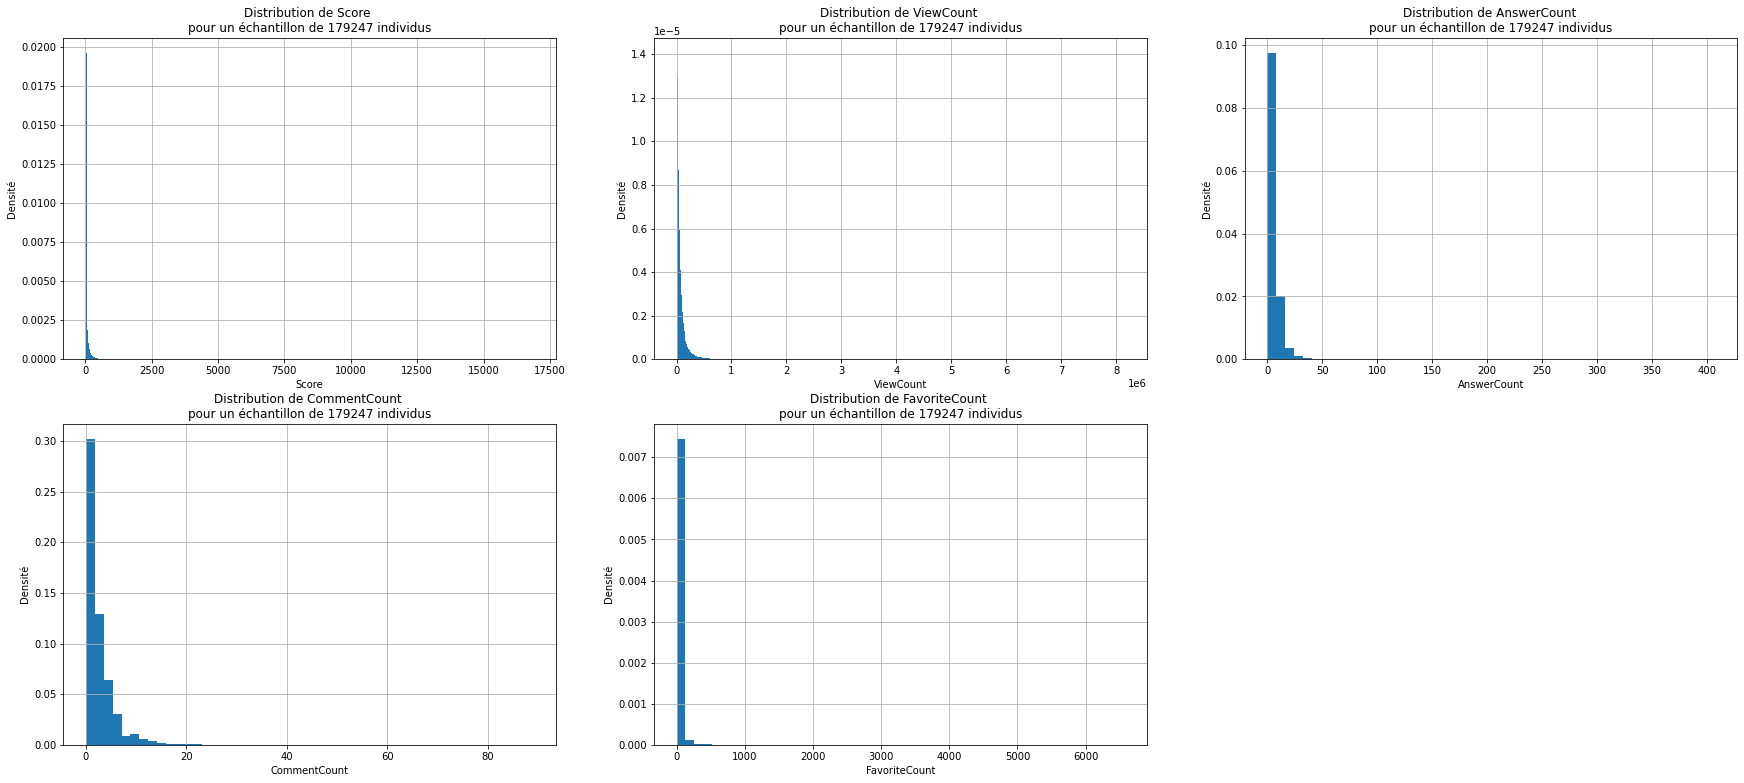

In [31]:
# Score des questions
plt.figure(figsize=(30, 13))
plt.subplot(231)
hist_plot(clean_train_2, 'Score', 500)
plt.subplot(232)
hist_plot(clean_train_2, 'ViewCount', 500)
plt.subplot(233)
hist_plot(clean_train_2, 'AnswerCount')
plt.subplot(234)
hist_plot(clean_train_2, 'CommentCount')
plt.subplot(235)
hist_plot(clean_train_2, 'FavoriteCount')

## C.2. Variables qualitatives

### C.2.a. Labels

In [32]:
all_clean_labels = [j for i in clean_train_2['clean_labels']
                    for j in i.split(", ") if j != '']

In [33]:
pd.Series(all_clean_labels).value_counts()

java                 18590
javascript           17541
python               17218
c#                   16861
android              14758
                     ...  
npm                    634
lambda                 633
spring-mvc             628
testing                622
language-agnostic      619
Length: 111, dtype: int64

In [34]:
freq = pd.Series(all_clean_labels).value_counts(normalize=True)

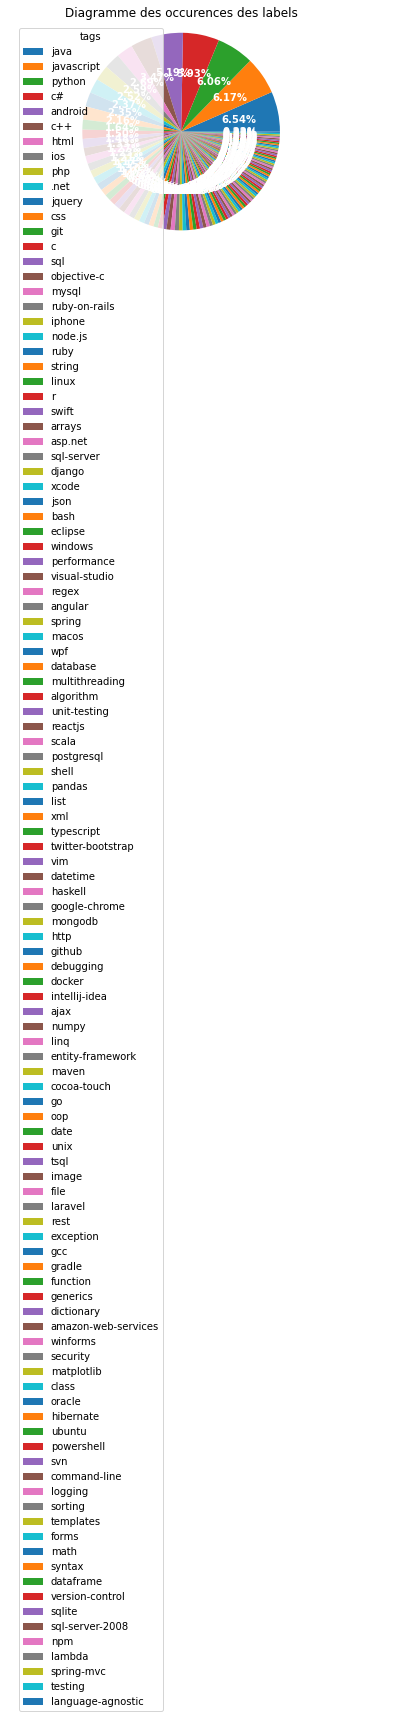

In [35]:
# frequence des tags
pie_plot(freq)

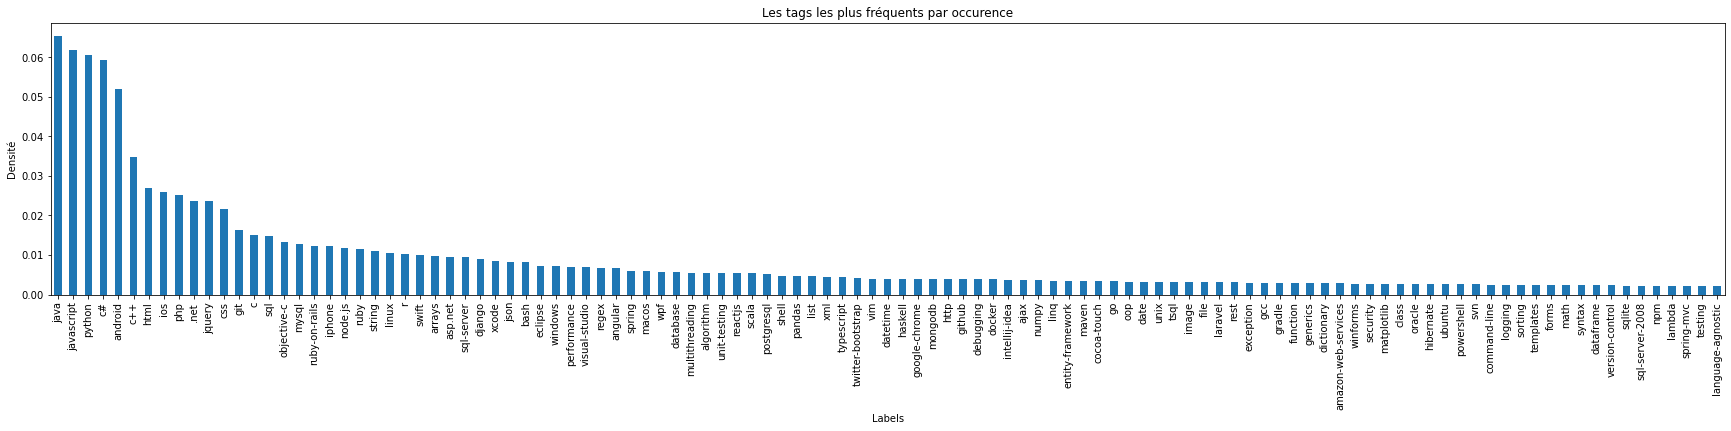

In [36]:
plt.figure(figsize=(30, 5))
plt.xlabel('Labels')
plt.ylabel('Densité')
freq.plot(kind='bar', title='Les tags les plus fréquents par occurence');

### C.2.b. Mots

In [37]:
all_words = [j for i in clean_train_2['clean_tokens'] for j in i if j != '']
freq_words = pd.Series(all_words).value_counts()

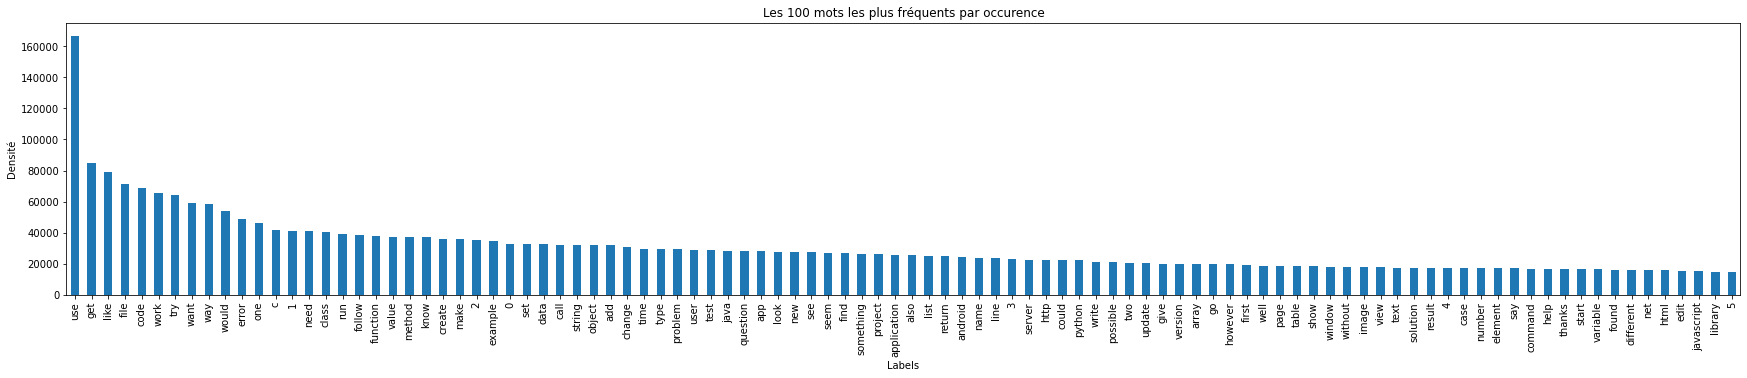

In [38]:
plt.figure(figsize=(30, 5))
plt.xlabel('Mots')
plt.ylabel('Densité')
plt.xticks(rotation=50)
freq_words[:100].plot(
    kind='bar', title='Les 100 mots les plus fréquents par occurence');

In [39]:
#Supprimer chiffre --> stop words

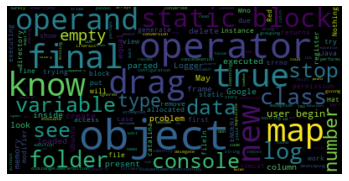

In [40]:
# Word cloud sur l'ensemble des posts
text = ' '.join([x for x in clean_train['full_text']])
#text = str(clean_train['full_text'].ravel())[1:-1]
wordcloud = WordCloud(width=800, height=500, random_state = 0, max_font_size=100).generate(text)
plt.figure(figsize=(15,15))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

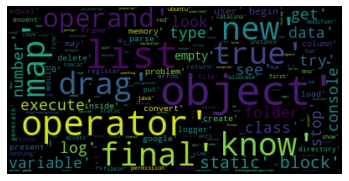

In [41]:
# Word cloud sur l'ensemble des posts
text = str(clean_train_2['clean_tokens'].ravel())[1:-1]
wordcloud = WordCloud(max_font_size=50).generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

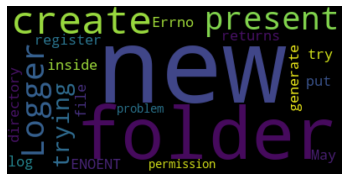

In [42]:
# Word cloud d'un post
wordcloud = WordCloud().generate(clean_train.loc[2,'full_text'])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off');

# D. Export des données

In [43]:
clean_train.to_csv('train_full_text.csv', index=False)
clean_train_2.to_csv('train_bag_of_words.csv', index=False)